In [1]:
%load_ext autoreload
%autoreload 2

from collections import defaultdict
import math
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle
import pycuber as pc
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

from classes.cube_classes import Cube3State, Cube3
from generate.generate_states import ids_to_color
from utils.random_seed import seed_worker, seed_all, init_weights
from utils.compressions import *

torch.set_default_dtype(torch.float64)

In [2]:
df = pd.read_pickle('data/5_moves_dataset_single.pkl')

In [3]:
len(df)

105045

In [4]:
def indices_to_position(indices):
    pos_array = np.array([
        [0.5, 0.5, 0], [1.5, 0.5, 0], [2.5, 0.5, 0],
        [0.5, 1.5, 0], [1.5, 1.5, 0], [2.5, 1.5, 0],
        [0.5, 2.5, 0], [1.5, 2.5, 0], [2.5, 2.5, 0],
        
        [2.5, 0.5, 3], [1.5, 0.5, 3], [0.5, 0.5, 3],
        [2.5, 1.5, 3], [1.5, 1.5, 3], [0.5, 1.5, 3],
        [2.5, 2.5, 3], [1.5, 2.5, 3], [0.5, 2.5, 3],
        
        [2.5, 0, 2.5], [2.5, 0, 1.5], [2.5, 0, 0.5],
        [1.5, 0, 2.5], [1.5, 0, 1.5], [1.5, 0, 0.5],
        [0.5, 0, 2.5], [0.5, 0, 1.5], [0.5, 0, 0.5],
        
        [0.5, 3, 2.5], [0.5, 3, 1.5], [0.5, 3, 0.5],
        [1.5, 3, 2.5], [1.5, 3, 1.5], [1.5, 3, 0.5],
        [2.5, 3, 2.5], [2.5, 3, 1.5], [2.5, 3, 0.5],
        
        [3, 2.5, 2.5], [3, 2.5, 1.5], [3, 2.5, 0.5],
        [3, 1.5, 2.5], [3, 1.5, 1.5], [3, 1.5, 0.5],
        [3, 0.5, 2.5], [3, 0.5, 1.5], [3, 0.5, 0.5],
        
        [0, 0.5, 2.5], [0, 0.5, 1.5], [0, 0.5, 0.5],
        [0, 1.5, 2.5], [0, 1.5, 1.5], [0, 1.5, 0.5],
        [0, 2.5, 2.5], [0, 2.5, 1.5], [0, 2.5, 0.5],
    ])
    return pos_array[np.array(indices)]

## 1. Volumes

In [5]:
import functools
from scipy.spatial import ConvexHull

In [6]:
@functools.lru_cache
def calc_volume(filtered_indices):
    vertices = indices_to_position(filtered_indices)
    if (vertices[:,0] == vertices[0,0]).all() or (vertices[:,1] == vertices[0,1]).all() or (vertices[:,2] == vertices[0,2]).all():
        volume = 0
    else:
        volume = ConvexHull(vertices).volume
    return volume

In [7]:
counterVolume = 0

In [8]:
def calc_volumes(colors, verbose=True, aggregate=False, for_hashing=False):
    if verbose:
        global counterVolume
        counterVolume += 1
        if (counterVolume + 1) % 1000 == 0:
            print(counterVolume+1)
    volumes = []
    indices = np.arange(54)
    colors = np.array(colors)
    for color in range(6):
        filtered_indices = indices[colors == color]
        volume = calc_volume(tuple(filtered_indices))
        if for_hashing:
            volume = np.rint(volume*10e4).astype(int)
        volumes.append(volume)
    volumes = np.array(volumes)
    if aggregate:
        volumes = np.sum(volumes, dtype=np.double)[..., np.newaxis]
    return volumes

In [9]:
cubeObj = Cube3()
goal = cubeObj.generate_goal_states(1)[0]
for i in range(12):
    next_state = cubeObj.prev_state([goal], i)[0]
#     print(next_state.colors)
    next_state_colors = next_state.colors//9
#     print(next_state_colors)
    print(calc_volumes(next_state_colors))
#     print()

[0.  0.  2.5 2.5 2.5 2.5]
[0.  0.  2.5 2.5 2.5 2.5]
[0.  0.  2.5 2.5 2.5 2.5]
[0.  0.  2.5 2.5 2.5 2.5]
[2.5 2.5 0.  0.  2.5 2.5]
[2.5 2.5 0.  0.  2.5 2.5]
[2.5 2.5 0.  0.  2.5 2.5]
[2.5 2.5 0.  0.  2.5 2.5]
[2.5 2.5 2.5 2.5 0.  0. ]
[2.5 2.5 2.5 2.5 0.  0. ]
[2.5 2.5 2.5 2.5 0.  0. ]
[2.5 2.5 2.5 2.5 0.  0. ]


In [10]:
class VolumeDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe):
        self.labels = dataframe['distance'].to_numpy(dtype=np.double)
        self.input = dataframe['colors'].map(calc_volumes).to_numpy()
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.input[idx], self.labels[idx]

In [359]:
datasetVolume = VolumeDataset(df)
trainloaderVolume = torch.utils.data.DataLoader(datasetVolume, batch_size=32, shuffle=True)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000


In [360]:
class VolumeNet(nn.Module):
    def __init__(self):
        super(VolumeNet, self).__init__()
        self.fcEmb = nn.Linear(1, 4)
        self.fc1 = nn.Linear(4, 1)

    def forward(self, x):
        x = x.view(-1, 1)
        x = self.fcEmb(x)
        x = x.view(-1, 6, 4)
        x = x.sum(dim=1)
        x = self.fc1(x)
        return x

In [361]:
volumeNet = VolumeNet()

In [362]:
def compute_loss(net, dataloader):
    net.eval()
    total_loss = 0
    total = 0
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            volumes, labels = data
            out = net(volumes)
            loss = F.mse_loss(out.squeeze(), labels)
            total_loss += loss.item()
            total += 1
    return total_loss / total

In [363]:
# Training loop
optimizerVolume = torch.optim.Adam(volumeNet.parameters(), lr=0.001)

for epoch in range(20):
    volumeNet.train()
    total = 0
    total_loss = 0.0
    for i, data in enumerate(trainloaderVolume):
        volumes, labels = data

        optimizerVolume.zero_grad()
        out = volumeNet(volumes)
        loss = F.mse_loss(out.squeeze(), labels, reduction='sum')
        loss.backward()
        total_loss += loss.item()
        total += labels.size(0)
        optimizerVolume.step()
    if (epoch+1) % 1 == 0:
        print(f'Epoch {epoch+1}: train loss {total_loss/total:0.4f}')

Epoch 1: train loss 13.8820
Epoch 2: train loss 0.5142
Epoch 3: train loss 0.2758
Epoch 4: train loss 0.2762
Epoch 5: train loss 0.2766
Epoch 6: train loss 0.2765
Epoch 7: train loss 0.2766
Epoch 8: train loss 0.2764
Epoch 9: train loss 0.2765
Epoch 10: train loss 0.2759
Epoch 11: train loss 0.2766
Epoch 12: train loss 0.2764
Epoch 13: train loss 0.2763
Epoch 14: train loss 0.2761
Epoch 15: train loss 0.2760
Epoch 16: train loss 0.2757
Epoch 17: train loss 0.2758
Epoch 18: train loss 0.2755
Epoch 19: train loss 0.2759
Epoch 20: train loss 0.2760


### Data compressions

In [11]:
distance_all_data_volume = calculate_all_dicts_from_data(df=df, max_distance=5, input_handling_func=calc_volumes)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93840/93840 [58:56<00:00, 26.54it/s]


In [12]:
print(distance_all_data_volume[0])
print(df[df['distance'] == 1])

defaultdict(<class 'list'>, {(0, 0, 250000, 250000, 250000, 250000): [(0, [["U'"]]), (1, [["R'"]]), (2, [["D'"]]), (3, [["L'"]]), (4, [["F'"]]), (5, [["B'"]]), (6, [['U']]), (7, [['R']]), (8, [['D']]), (9, [['L']]), (10, [['F']]), (11, [['B']])]})
                                                state  \
0   <classes.cube_classes.Cube3State object at 0x0...   
1   <classes.cube_classes.Cube3State object at 0x0...   
2   <classes.cube_classes.Cube3State object at 0x0...   
3   <classes.cube_classes.Cube3State object at 0x0...   
4   <classes.cube_classes.Cube3State object at 0x0...   
5   <classes.cube_classes.Cube3State object at 0x0...   
6   <classes.cube_classes.Cube3State object at 0x0...   
7   <classes.cube_classes.Cube3State object at 0x0...   
8   <classes.cube_classes.Cube3State object at 0x0...   
9   <classes.cube_classes.Cube3State object at 0x0...   
10  <classes.cube_classes.Cube3State object at 0x0...   
11  <classes.cube_classes.Cube3State object at 0x0...   

          

In [13]:
with open('data/temp/distance_all_data_volume_single.pkl', 'wb') as f:
    pickle.dump(distance_all_data_volume, f)

In [14]:
set_intersections_data_volume = compute_set_intersections(distance_all_data_volume)

Intersection size between sets 1 AND 2: 0
Intersection size between sets 1 AND 3: 0
Intersection size between sets 1 AND 4: 0
Intersection size between sets 1 AND 5: 0
Intersection size between sets 2 AND 3: 0
Intersection size between sets 2 AND 4: 0
Intersection size between sets 2 AND 5: 0
Intersection size between sets 3 AND 4: 0
Intersection size between sets 3 AND 5: 0
Intersection size between sets 4 AND 5: 0


In [15]:
# INTERSECTION_BETWEEN = (2,3)
# common_activation = list(set_intersections_data_volume[INTERSECTION_BETWEEN])[0]
# gen1 = distance_all_data_volume[INTERSECTION_BETWEEN[0] - 1][common_activation][0][1][0]
# print(gen1)
# gen2 = distance_all_data_volume[INTERSECTION_BETWEEN[1] - 1][common_activation][0][1][0]
# print(gen2)

# cube1 = pc.Cube()
# print(' '.join(gen1))
# cube1(' '.join(gen1))
# display(cube1)

# cube2 = pc.Cube()
# print(' '.join(gen2))
# cube2(' '.join(gen2))
# display(cube2)

In [17]:
# common_activation

In [51]:
# distance_all_data_volume[0]

In [52]:
# distance_all_data_volume[1]

In [20]:
ccc = pc.Cube()
print(' '.join(['U', 'D']))
ccc(' '.join(['U', 'D']))
display(ccc)

U D


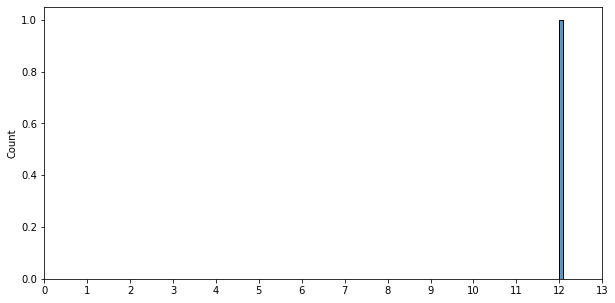

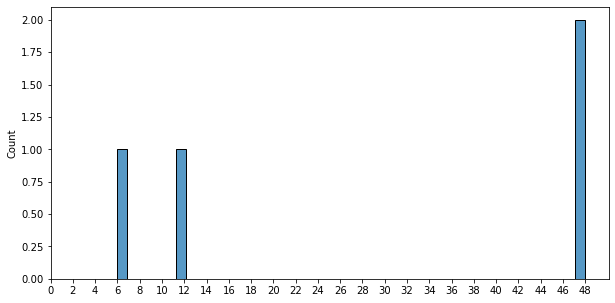

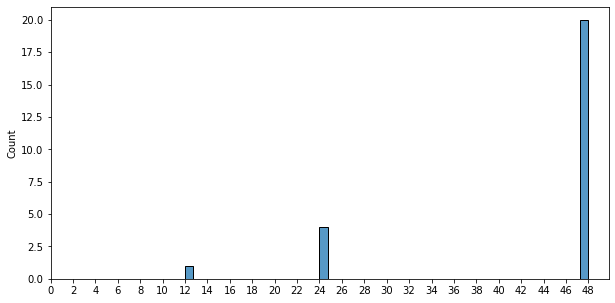

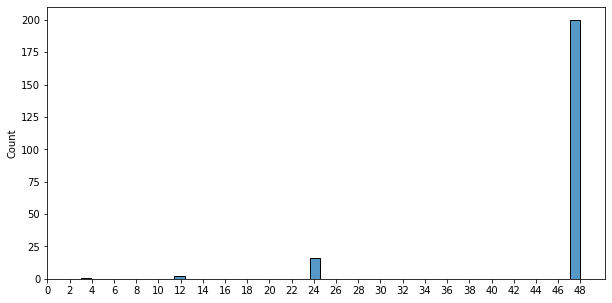

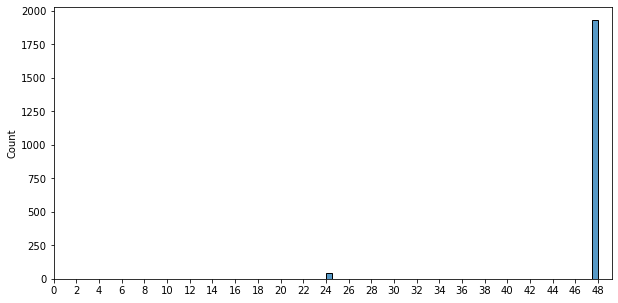

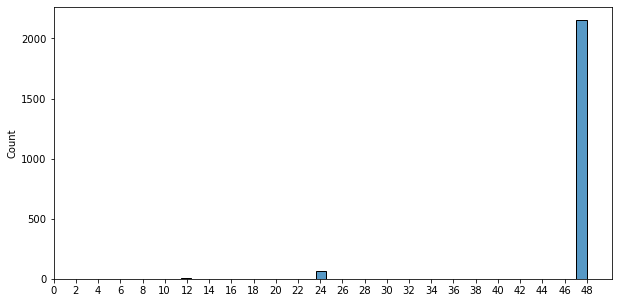

In [21]:
plot_distance_compressions(distance_all_data_volume, 'volumeNet/from_data')

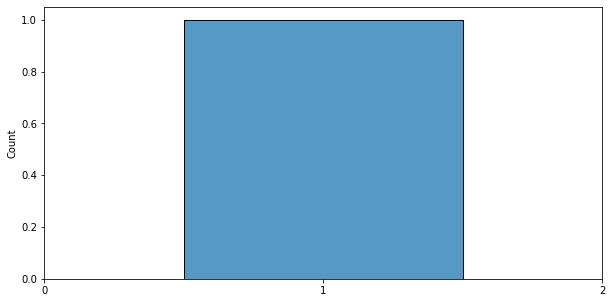

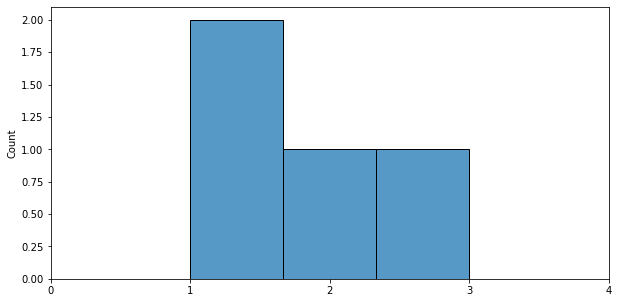

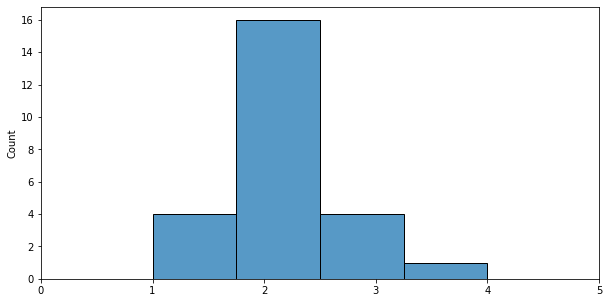

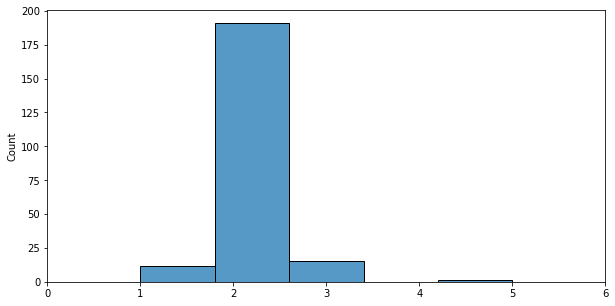

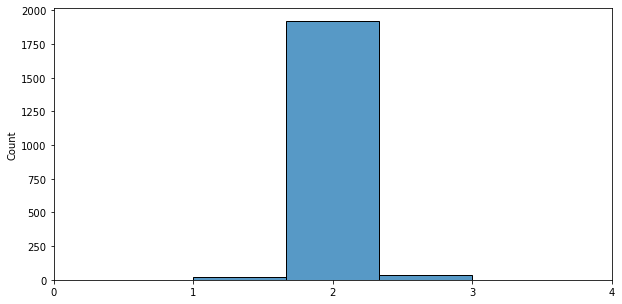

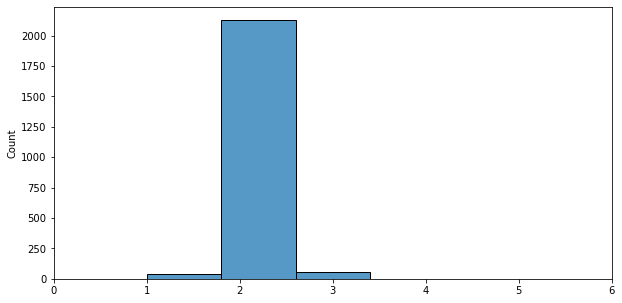

In [22]:
plot_class_ids_per_compressions(distance_all_data_volume, df, 'volumeNet/from_data')

In [23]:
for key, items in distance_all_data_volume[0].items():
    if not items: continue
    i, _ = items[0]
    if df.iloc[i]['class_id'] == 0:
        print(key)
        print()

(0, 0, 250000, 250000, 250000, 250000)



### Activation compressions

In [608]:
networksVolume = create_networks(NetworkClass=VolumeNet, num_of_networks=10)
distance_all_acts_volume = calculate_all_dicts_from_activations(df=df, max_distance=3, input_handling_func=calc_volumes, networks=networksVolume)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1068/1068 [00:37<00:00, 28.27it/s]


In [609]:
with open('data/temp/distance_all_acts_volume.pkl', 'wb') as f:
    pickle.dump(distance_all_acts_volume, f)

In [610]:
set_intersections_activations_volume = compute_set_intersections(distance_all_acts_volume)

Intersection size between sets 1 AND 2: 0
Intersection size between sets 1 AND 3: 0
Intersection size between sets 2 AND 3: 1


In [611]:
INTERSECTION_BETWEEN = (2,3)
common_activation = list(set_intersections_activations_volume[INTERSECTION_BETWEEN])[0]
gen1 = distance_all_acts_volume[INTERSECTION_BETWEEN[0] - 1][common_activation][0][1][0]
print(gen1)
gen2 = distance_all_acts_volume[INTERSECTION_BETWEEN[1] - 1][common_activation][0][1][0]
print(gen2)

cube1 = pc.Cube()
print(' '.join(gen1))
cube1(' '.join(gen1))
display(cube1)

cube2 = pc.Cube()
print(' '.join(gen2))
cube2(' '.join(gen2))
display(cube2)

["U'", "L'"]
["U'", "L'", 'U']
U' L'


U' L' U


In [612]:
common_activation

(-536785763,
 55656188,
 306566443,
 -398109530,
 1080535414,
 286733350,
 766169209,
 -1044275018,
 -521015891,
 1026203807)

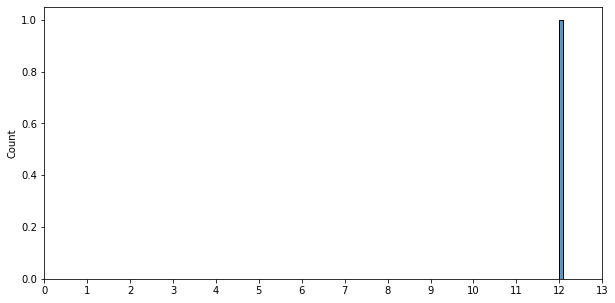

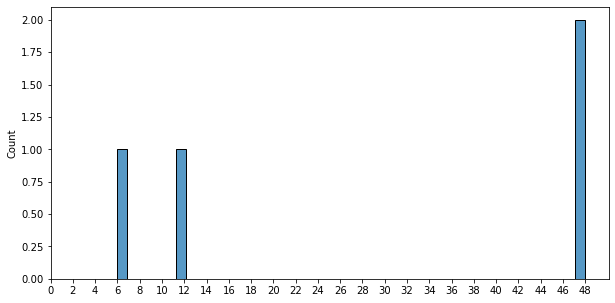

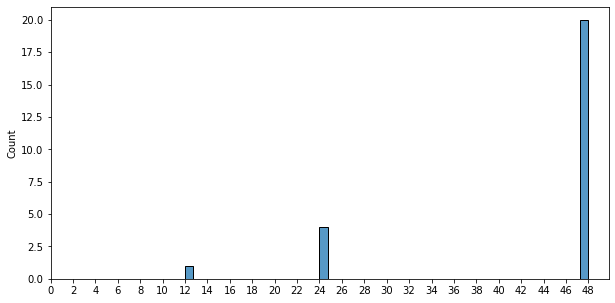

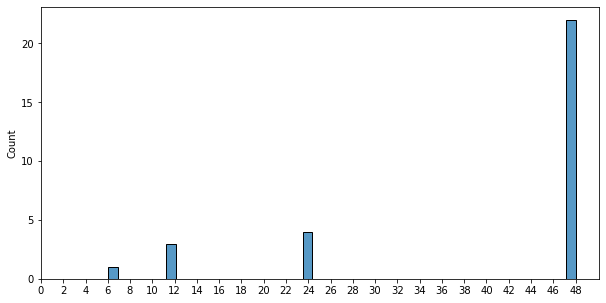

In [613]:
plot_distance_compressions(distance_all_acts_volume, 'volumeNet/from_activations')

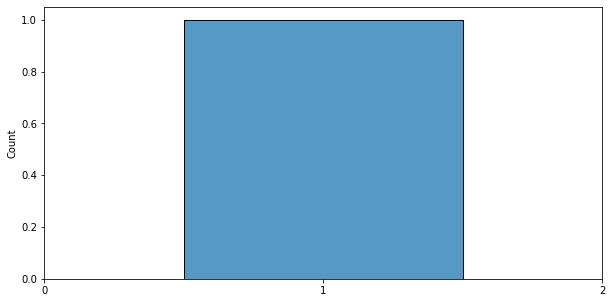

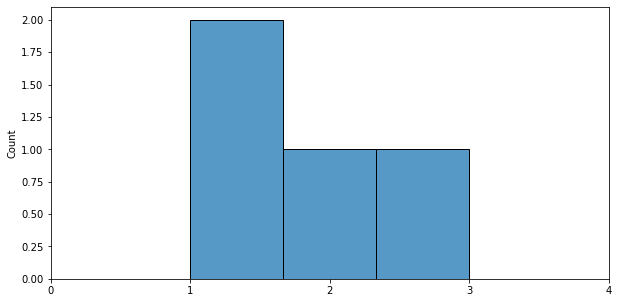

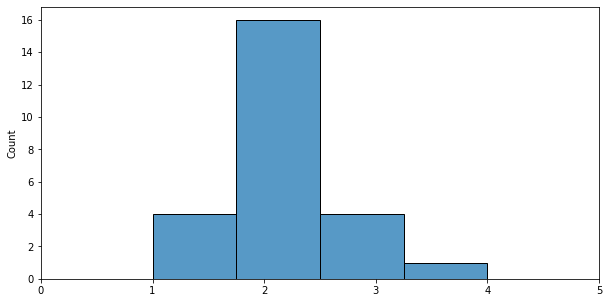

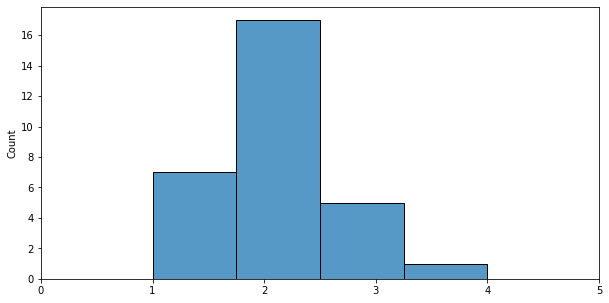

In [614]:
plot_class_ids_per_compressions(distance_all_acts_volume, df, 'volumeNet/from_activations')

---

## 2. Distances

In [24]:
counterDist = 0

In [25]:
def find_middle(vertices):
    for vertex in vertices:
        if (vertex[0] == vertex[1] == 1.5) or (vertex[0] == vertex[2] == 1.5) or (vertex[1] == vertex[2] == 1.5):
            return vertex
    return None

In [26]:
@functools.lru_cache
def calc_distances(filtered_indices):
    vertices = indices_to_position(filtered_indices)
    middle = find_middle(vertices)
    distances = np.linalg.norm(vertices - middle.reshape(1, -1), axis=1)
    distances = distances[distances != 0]
    # zprojektovat a pak secist?
    distances = np.sort(distances)
    return distances

In [27]:
def calc_all_distances(colors, verbose=True, aggregate=False, for_hashing=False):
    if verbose:
        global counterDist
        counterDist += 1
        if (counterDist + 1) % 1000 == 0:
            print(counterDist+1)
    distances_ls = []
    indices = np.arange(54)
    colors = np.array(colors)
    for color in range(6):
        filtered_indices = indices[colors == color]
        distances = calc_distances(tuple(filtered_indices))
        if for_hashing:
            distances = np.rint(distances*10e4).astype(int)
        distances_ls.append(distances)
    distances_ls = np.array(distances_ls)
    if aggregate:
        distances_ls = np.sum(distances_ls, axis=0, dtype=np.double)
    return distances_ls

In [28]:
cubeObj = Cube3()
goal = cubeObj.generate_goal_states(1)[0]
for i in range(4):
    next_state = cubeObj.prev_state([goal], i)[0]
#     print((next_state.colors // 9).reshape(6,9))
    next_state_colors = next_state.colors//9
#     print(next_state_colors)
    print(calc_all_distances(next_state_colors, aggregate=True))
    print()

[ 6.          6.          6.          7.65685425  8.48528137 10.3117419
 12.20925864 15.15725513]

[ 6.          6.          6.          7.65685425  8.48528137 10.3117419
 12.20925864 15.15725513]

[ 6.          6.          6.          7.65685425  8.48528137 10.3117419
 12.20925864 15.15725513]

[ 6.          6.          6.          7.65685425  8.48528137 10.3117419
 12.20925864 15.15725513]



In [894]:
class DistancesDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe):
        self.labels = dataframe['distance'].to_numpy(dtype=np.double)
        self.input = dataframe['colors'].map(calc_all_distances).to_numpy()
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.input[idx], self.labels[idx]

In [509]:
datasetDist = DistancesDataset(df)
trainloaderDist = torch.utils.data.DataLoader(datasetDist, batch_size=32, shuffle=True)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000


In [510]:
class DistNet(nn.Module):
    def __init__(self):
        super(DistNet, self).__init__()
        self.fcEmb = nn.Linear(8, 16)
        self.fc1 = nn.Linear(16, 16)
        self.fc2 = nn.Linear(16, 1)

    def forward(self, x):
        x = x.view(-1, 8)
        x = self.fcEmb(x)
        x = x.view(-1, 6, 16)
        x = x.sum(dim=1)
        x = F.relu(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [511]:
distNet = DistNet()

In [512]:
## Training loop
optimizerDist = torch.optim.Adam(distNet.parameters(), lr=0.001)

for epoch in range(20):
    distNet.train()
    total = 0
    total_loss = 0.0
    for i, data in enumerate(trainloaderDist):
        distances, labels = data

        optimizerDist.zero_grad()
        out = distNet(distances)
        loss = F.mse_loss(out.squeeze(), labels, reduction='sum')
        loss.backward()
        total_loss += loss.item()
        total += labels.size(0)
        optimizerDist.step()
    if (epoch+1) % 1 == 0:
        print(f'Epoch {epoch+1}: train loss {total_loss/total:0.4f}')

Epoch 1: train loss 0.4405
Epoch 2: train loss 0.2731
Epoch 3: train loss 0.2693
Epoch 4: train loss 0.2670
Epoch 5: train loss 0.2654
Epoch 6: train loss 0.2642
Epoch 7: train loss 0.2603
Epoch 8: train loss 0.2576
Epoch 9: train loss 0.2552
Epoch 10: train loss 0.2529
Epoch 11: train loss 0.2509
Epoch 12: train loss 0.2488
Epoch 13: train loss 0.2488
Epoch 14: train loss 0.2467
Epoch 15: train loss 0.2451
Epoch 16: train loss 0.2427
Epoch 17: train loss 0.2398
Epoch 18: train loss 0.2395
Epoch 19: train loss 0.2375
Epoch 20: train loss 0.2366


### Data compressions

In [29]:
distance_all_data_dist = calculate_all_dicts_from_data(df=df, max_distance=5, input_handling_func=calc_all_distances)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93840/93840 [02:28<00:00, 632.09it/s]


In [30]:
for key, value in distance_all_data_dist[0].items():
    print(key)
    print(value)
    print('=============================')

(2094680574950802944, 2094680574950802944, 2094680574950802944, 2094680574950802944, 3090165215822276824, 3090165215822276824)
[(0, [["U'"]]), (1, [["R'"]]), (2, [["D'"]]), (3, [["L'"]]), (4, [["F'"]]), (5, [["B'"]]), (6, [['U']]), (7, [['R']]), (8, [['D']]), (9, [['L']]), (10, [['F']]), (11, [['B']])]


In [31]:
with open('data/temp/distance_all_data_dist.pkl', 'wb') as f:
    pickle.dump(distance_all_data_dist, f)

In [32]:
set_intersections_data_dist = compute_set_intersections(distance_all_data_dist)

Intersection size between sets 1 AND 2: 0
Intersection size between sets 1 AND 3: 0
Intersection size between sets 1 AND 4: 0
Intersection size between sets 1 AND 5: 0
Intersection size between sets 2 AND 3: 0
Intersection size between sets 2 AND 4: 0
Intersection size between sets 2 AND 5: 0
Intersection size between sets 3 AND 4: 0
Intersection size between sets 3 AND 5: 3
Intersection size between sets 4 AND 5: 0


In [57]:
INTERSECTION_BETWEEN = (3,5)
common_activation = list(set_intersections_data_dist[INTERSECTION_BETWEEN])[0]
gen1 = distance_all_data_dist[INTERSECTION_BETWEEN[0] - 1][common_activation][0][1][0]
print(gen1)
gen2 = distance_all_data_dist[INTERSECTION_BETWEEN[1] - 1][common_activation][0][1][0]
print(gen2)

cube1 = pc.Cube()
print(' '.join(gen1))
cube1(' '.join(gen1))
display(cube1)

cube2 = pc.Cube()
print(' '.join(gen2))
cube2(' '.join(gen2))
display(cube2)

["U'", 'L', 'F']
["U'", "U'", "L'", 'U', 'B']
U' L F


U' U' L' U B


In [58]:
# distance_all_data_dist[1]

In [59]:
# distance_all_data_dist[2]

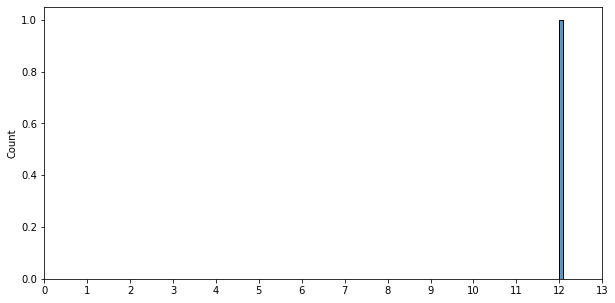

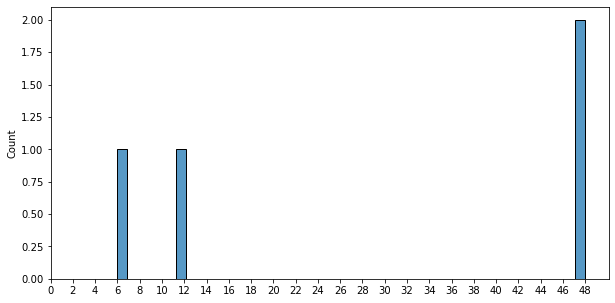

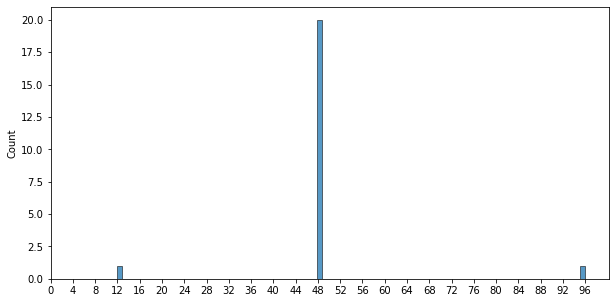

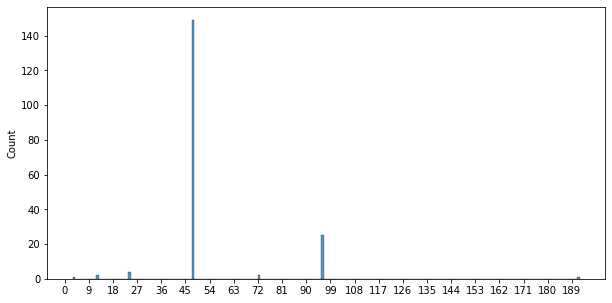

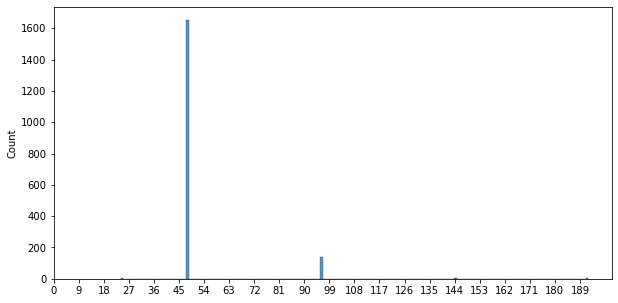

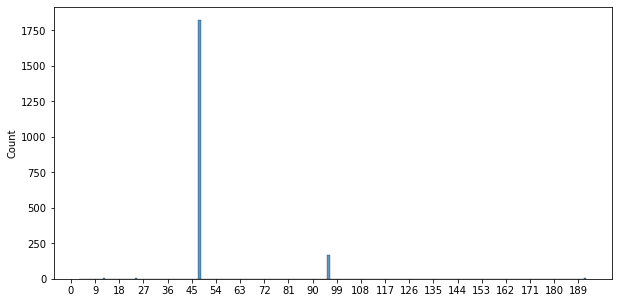

In [36]:
plot_distance_compressions(distance_all_data_dist, 'distNet/from_data')

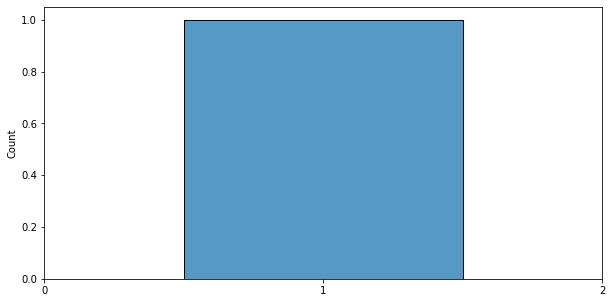

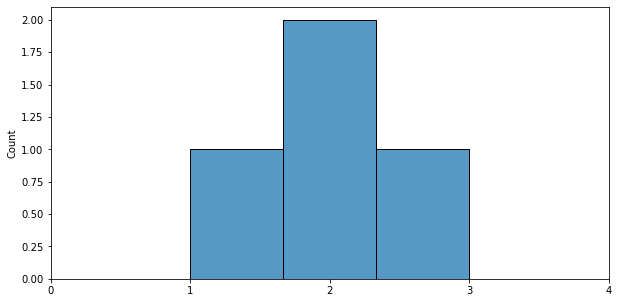

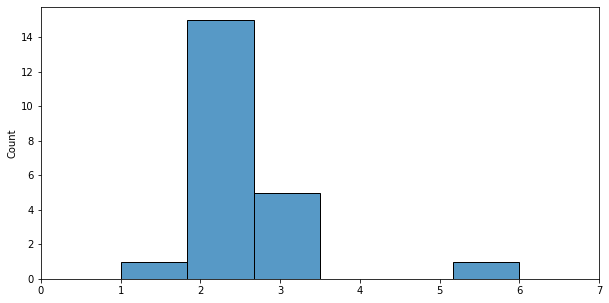

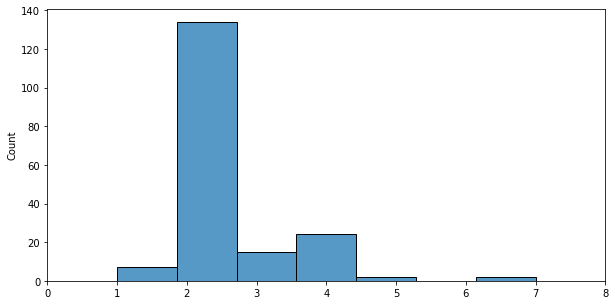

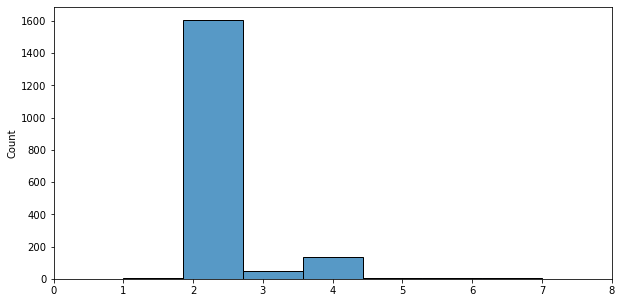

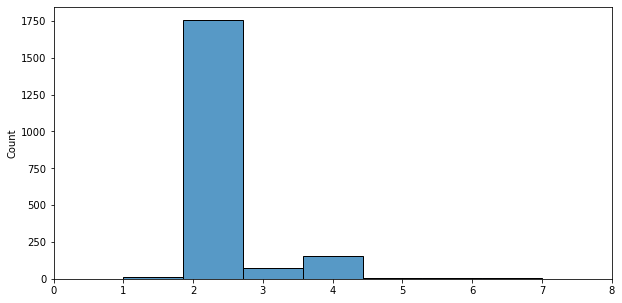

In [37]:
plot_class_ids_per_compressions(distance_all_data_dist, df, 'distNet/from_data')

In [38]:
for key, items in distance_all_data_dist[0].items():
    if not items: continue
    i, _ = items[0]
    if df.iloc[i]['class_id'] == 0:
        print(key)
        print()

(2094680574950802944, 2094680574950802944, 2094680574950802944, 2094680574950802944, 3090165215822276824, 3090165215822276824)



### Activation compressions

In [629]:
networksDist = create_networks(NetworkClass=DistNet, num_of_networks=10)
distance_all_acts_dist = calculate_all_dicts_from_activations(df=df, max_distance=3, input_handling_func=calc_all_distances, networks=networksDist)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1068/1068 [00:06<00:00, 169.60it/s]


In [630]:
with open('data/temp/distance_all_acts_dist.pkl', 'wb') as f:
    pickle.dump(distance_all_acts_dist, f)

In [631]:
set_intersections_activations_dist = compute_set_intersections(distance_all_acts_dist)

Intersection size between sets 1 AND 2: 0
Intersection size between sets 1 AND 3: 0
Intersection size between sets 2 AND 3: 0


In [633]:
# common_activation = list(set_intersections_activations_dist[(4,5)])[0]
# gen1 = distance_all_acts_dist[3][common_activation][0][1][0]
# print(gen1)
# gen2 = distance_all_acts_dist[4][common_activation][0][1][0]
# print(gen2)

# cube1 = pc.Cube()
# print(' '.join(gen1))
# cube1(' '.join(gen1))
# display(cube1)

# cube2 = pc.Cube()
# print(' '.join(gen2))
# cube2(' '.join(gen2))
# display(cube2)

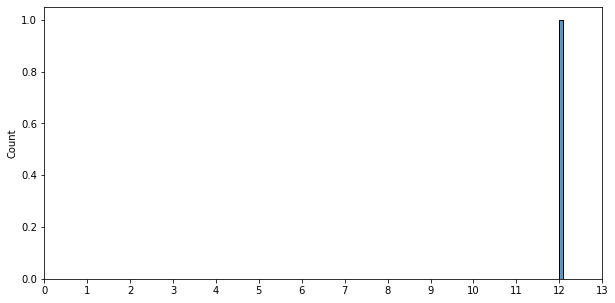

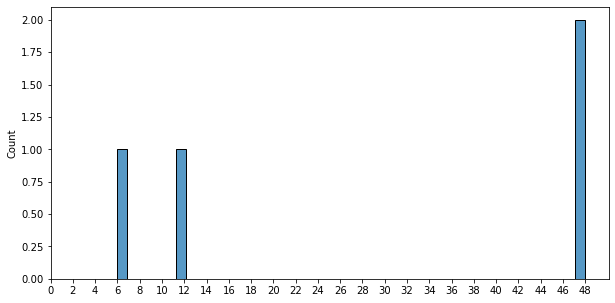

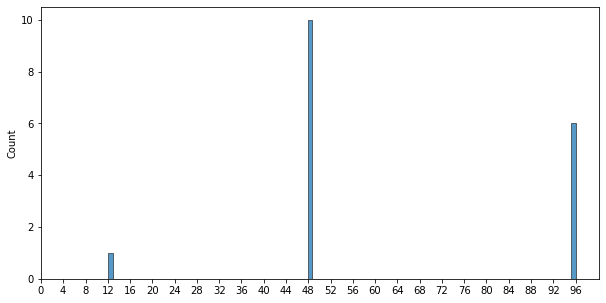

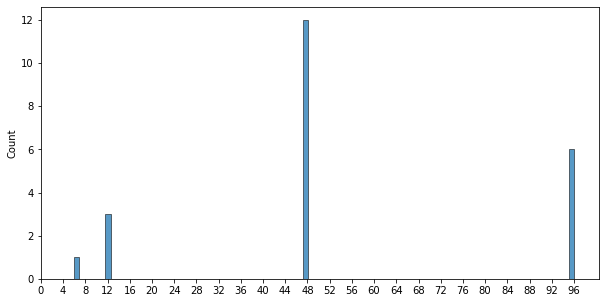

In [634]:
plot_distance_compressions(distance_all_acts_dist, 'distNet/from_activations')

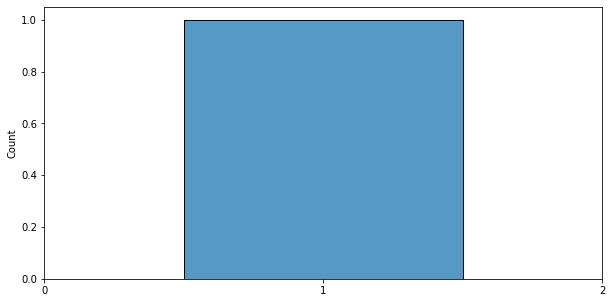

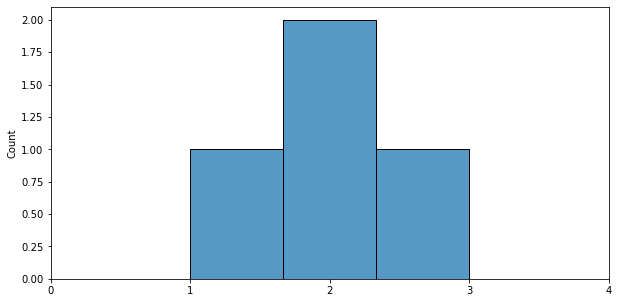

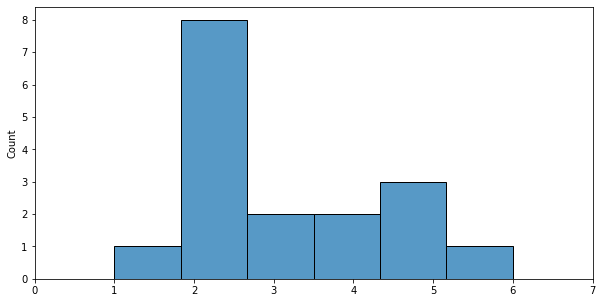

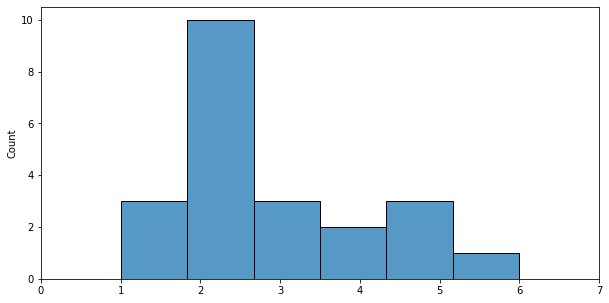

In [635]:
plot_class_ids_per_compressions(distance_all_acts_dist, df, 'distNet/from_activations')

---

## 3. Angles

In [39]:
counterAngles = 0

In [40]:
def unit_vector(vector):
    """ Returns the unit vector of the vector. """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2' """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.abs(np.arccos(np.dot(v1_u, v2_u)))

In [41]:
@functools.lru_cache
def calc_angles(filtered_indices):
    vertices = indices_to_position(filtered_indices)
    middle = find_middle(vertices)
    distances = np.linalg.norm(vertices - middle.reshape(1, -1), axis=1)
    vertices = vertices[distances != 0]  # - middle,  np.zeros(3)
    angles = [angle_between(v, middle) for v in vertices]
    angles = np.sort(angles)
    return angles

In [42]:
def calc_all_angles(colors, verbose=True, aggregate=False, for_hashing=False):
    if verbose:
        global counterAngles
        counterAngles += 1
        if (counterAngles + 1) % 10000 == 0:
            print(counterAngles+1)
    angles_ls = []
    indices = np.arange(54)
    colors = np.array(colors)
    for color in range(6):
#         print('color', color)
        filtered_indices = indices[colors == color]
        angles = calc_angles(tuple(filtered_indices))
        if for_hashing:
            angles = np.rint(angles*10e4).astype(int)
#         print(angles)
        angles_ls.append(angles)
#         print('---')
    angles_ls = np.array(angles_ls)
    if aggregate:
        angles_ls = np.sum(angles_ls, axis=0, dtype=np.double)
#     print('=================')
    return angles_ls

In [909]:
class AnglesDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe):
        self.labels = dataframe['distance'].to_numpy(dtype=np.double)
        self.input = dataframe['colors'].map(calc_all_angles).to_numpy()
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.input[idx], self.labels[idx]

In [ ]:
datasetAngles = AnglesDataset(df)
trainloaderAngles = torch.utils.data.DataLoader(datasetAngles, batch_size=32, shuffle=True)

In [534]:
class AnglesNet(nn.Module):
    def __init__(self):
        super(AnglesNet, self).__init__()
        self.fcEmb = nn.Linear(8, 16)
        self.fc1 = nn.Linear(16, 16)
        self.fc2 = nn.Linear(16, 1)

    def forward(self, x):
        x = x.view(-1, 8)
        x = self.fcEmb(x)
        x = x.view(-1, 6, 16)
        x = x.sum(dim=1)
        x = F.relu(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [535]:
anglesNet = AnglesNet()

In [ ]:
## Training loop
optimizerAngles = torch.optim.Adam(anglesNet.parameters(), lr=0.001)

for epoch in range(50):
    anglesNet.train()
    total = 0
    total_loss = 0.0
    for i, data in enumerate(trainloaderAngles):
        angles, labels = data

        optimizerAngles.zero_grad()
        out = anglesNet(angles)
        loss = F.mse_loss(out.squeeze(), labels, reduction='sum')
        loss.backward()
        total_loss += loss.item()
        total += labels.size(0)
        optimizerAngles.step()
    if (epoch+1) % 1 == 0:
        print(f'Epoch {epoch+1}: train loss {total_loss/total:0.4f}')

### Data compressions

In [43]:
distance_all_data_angle = calculate_all_dicts_from_data(df=df, max_distance=5, input_handling_func=calc_all_angles)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93840/93840 [07:20<00:00, 212.81it/s]


In [44]:
with open('data/temp/distance_all_data_angle.pkl', 'wb') as f:
    pickle.dump(distance_all_data_angle, f)

In [45]:
set_intersections_data_angle = compute_set_intersections(distance_all_data_angle)

Intersection size between sets 1 AND 2: 0
Intersection size between sets 1 AND 3: 0
Intersection size between sets 1 AND 4: 0
Intersection size between sets 1 AND 5: 0
Intersection size between sets 2 AND 3: 0
Intersection size between sets 2 AND 4: 0
Intersection size between sets 2 AND 5: 0
Intersection size between sets 3 AND 4: 0
Intersection size between sets 3 AND 5: 0
Intersection size between sets 4 AND 5: 0


In [54]:
# distance_all_data_angle[0]

In [53]:
# distance_all_data_angle[1]

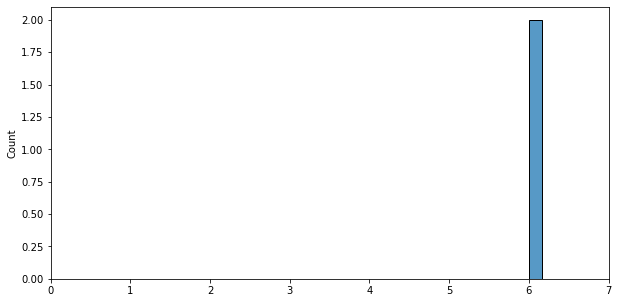

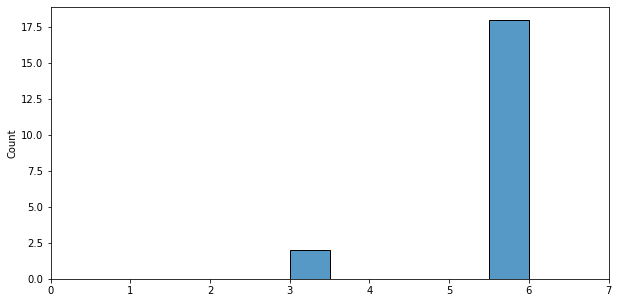

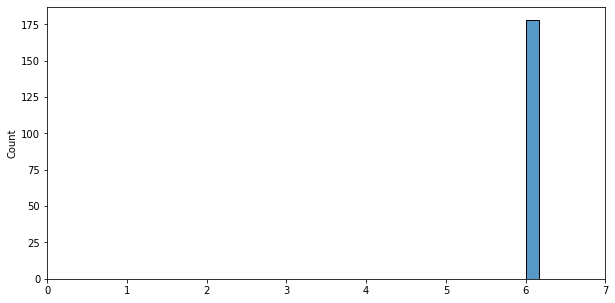

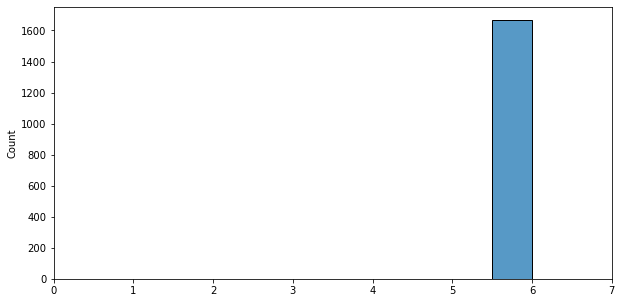

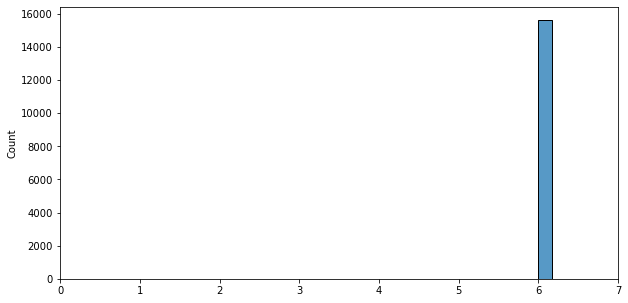

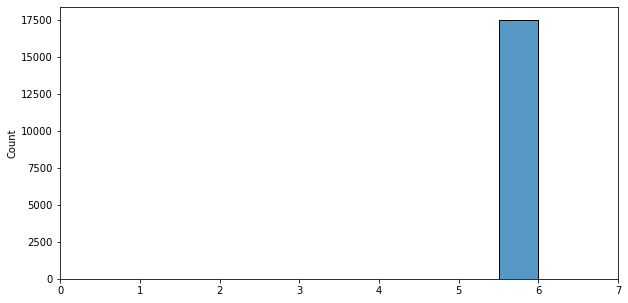

In [48]:
plot_distance_compressions(distance_all_data_angle, 'angleNet/from_data')

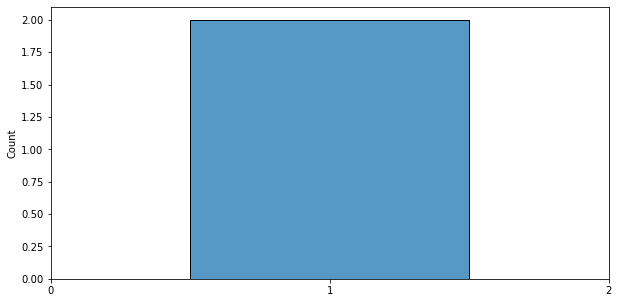

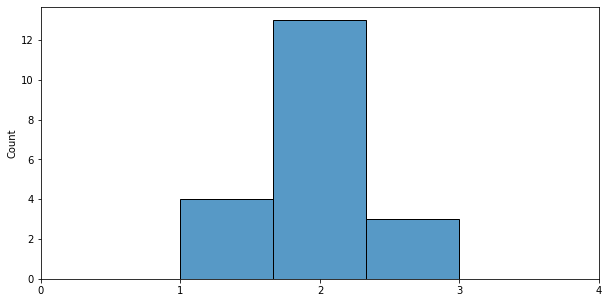

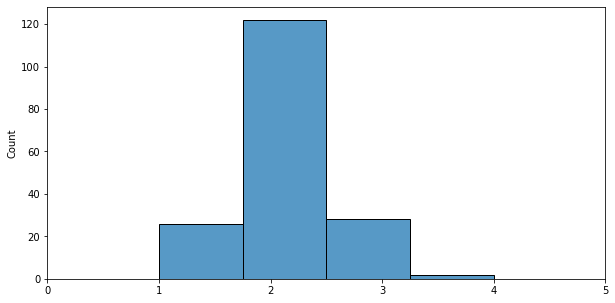

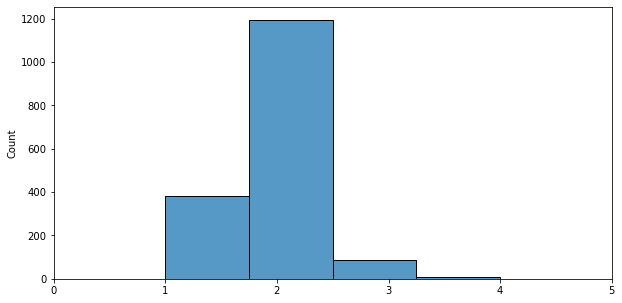

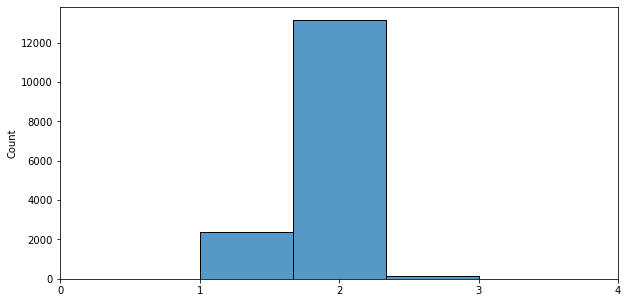

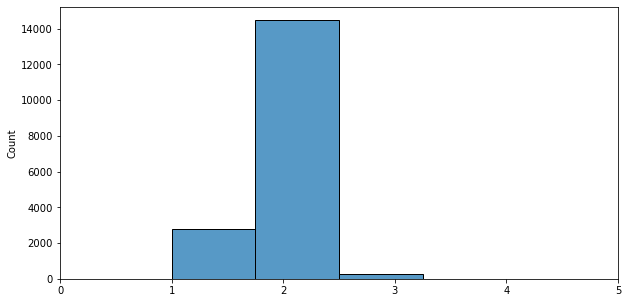

In [49]:
plot_class_ids_per_compressions(distance_all_data_angle, df, 'angleNet/from_data')

In [50]:
for key, items in distance_all_data_angle[0].items():
    if not items: continue
    i, _ = items[0]
    if df.iloc[i]['class_id'] == 0:
        print(key)
        print()

(-8533298520230643354, -6714101169122378021, -2668674007782087694, 342415276742463891, 1052110674201469607, 1612056655394432962)

(-1677050653064955247, 833400481228554777, 1041029807598366271, 1052110674201469607, 1612056655394432962, 3610372851657193425)



---

## 4. Distances + Angles

In [799]:
counterDistAngles = 0

In [800]:
def unit_vector(vector):
    """ Returns the unit vector of the vector. """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2' """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

In [801]:
@functools.lru_cache
def calc_distances_angles(filtered_indices):
    vertices = indices_to_position(filtered_indices)
    middle = find_middle(vertices)
    distances = np.linalg.norm(vertices - middle.reshape(1, -1), axis=1)
    angles = angle_between(vertices[distances != 0], middle)
    distances = distances[distances != 0]
    sorted_indices = np.lexsort((distances, angles))
    distances = distances[sorted_indices]
    angles = angles[sorted_indices]
    return np.concatenate((distances, angles), axis=0)

In [802]:
def calc_all_distances_angles(colors, verbose=True, aggregate=False, for_hashing=False):
    if verbose:
        global counterDistAngles
        counterDistAngles += 1
        if (counterDistAngles + 1) % 10000 == 0:
            print(counterDistAngles+1)
    distances_angles_ls = []
    indices = np.arange(54)
    colors = np.array(colors)
    for color in range(6):
        filtered_indices = indices[colors == color]
        distances_angles = calc_distances_angles(tuple(filtered_indices))
        if for_hashing:
            distances_angles = np.rint(distances_angles*10e4).astype(int)
        distances_angles_ls.append(distances_angles)
    distances_angles_ls = np.array(distances_angles_ls)
    if aggregate:
        distances_angles_ls = np.sum(distances_angles_ls, axis=0, dtype=np.double)
    else:
        distances_angles_ls = np.sort(distances_angles_ls)
    return distances_angles_ls

In [ ]:
class DistancesAnglesDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe):
        self.labels = dataframe['distance'].to_numpy(dtype=np.double)
        self.input = dataframe['colors'].map(calc_all_distances_angles).to_numpy()
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.input[idx], self.labels[idx]

In [ ]:
datasetDistAngles = DistancesAnglesDataset(df)
trainloaderDistAngles = torch.utils.data.DataLoader(datasetDistAngles, batch_size=32, shuffle=True)

In [534]:
class DistAnglesNet(nn.Module):
    def __init__(self):
        super(DistAnglesNet, self).__init__()
        self.fcEmb = nn.Linear(16, 32)
        self.fc1 = nn.Linear(32, 16)
        self.fc2 = nn.Linear(16, 1)

    def forward(self, x):
        x = x.view(-1, 16)
        x = self.fcEmb(x)
        x = x.view(-1, 6, 32)
        x = x.sum(dim=1)
        x = F.relu(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [535]:
distAnglesNet = DistAnglesNet()

In [ ]:
## Training loop
optimizerDistAngles = torch.optim.Adam(distAnglesNet.parameters(), lr=0.001)

for epoch in range(50):
    distAnglesNet.train()
    total = 0
    total_loss = 0.0
    for i, data in enumerate(trainloaderDistAngles):
        distances_angles, labels = data

        optimizerDistAngles.zero_grad()
        out = distAnglesNet(distances_angles)
        loss = F.mse_loss(out.squeeze(), labels, reduction='sum')
        loss.backward()
        total_loss += loss.item()
        total += labels.size(0)
        optimizerDistAngles.step()
    if (epoch+1) % 1 == 0:
        print(f'Epoch {epoch+1}: train loss {total_loss/total:0.4f}')

### Data compressions

In [803]:
distance_all_data_dist_angle = calculate_all_dicts_from_data(df=df, max_distance=4, input_handling_func=calc_all_distances_angles)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10011/10011 [00:22<00:00, 446.69it/s]


In [804]:
with open('data/temp/distance_all_data_dist_angle.pkl', 'wb') as f:
    pickle.dump(distance_all_data_dist_angle, f)

In [805]:
set_intersections_data_dist_angle = compute_set_intersections(distance_all_data_dist_angle)

Intersection size between sets 1 AND 2: 0
Intersection size between sets 1 AND 3: 0
Intersection size between sets 1 AND 4: 0
Intersection size between sets 2 AND 3: 0
Intersection size between sets 2 AND 4: 0
Intersection size between sets 3 AND 4: 0


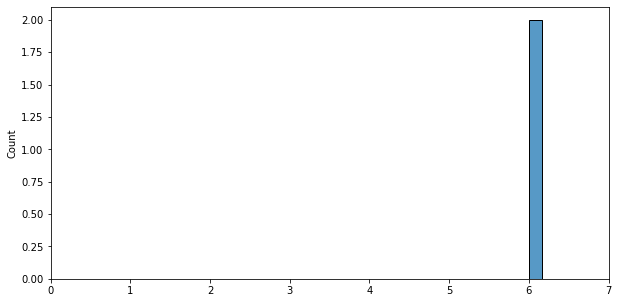

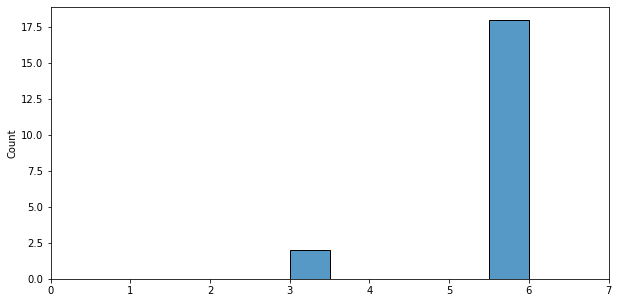

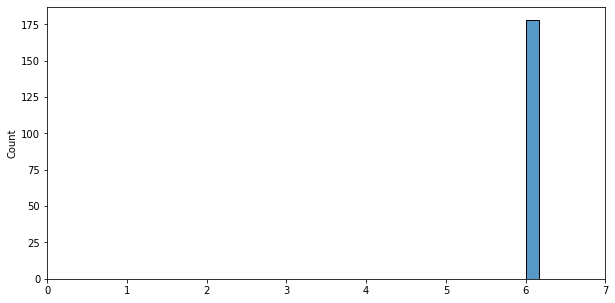

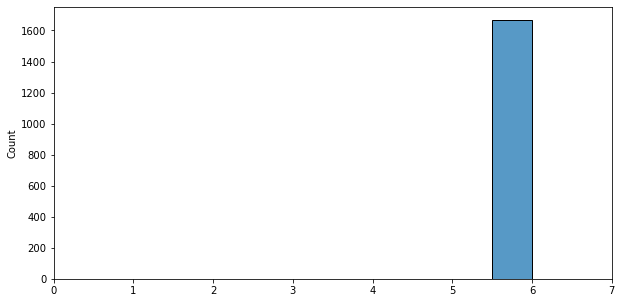

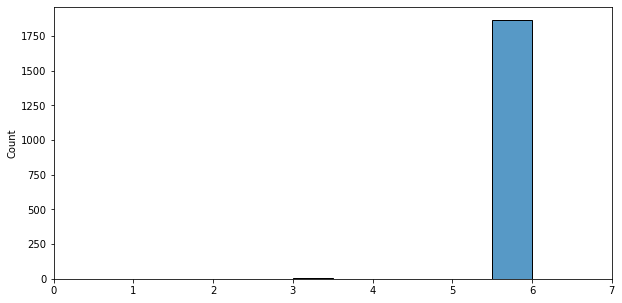

In [806]:
plot_distance_compressions(distance_all_data_dist_angle, 'distAngleNet/from_data')

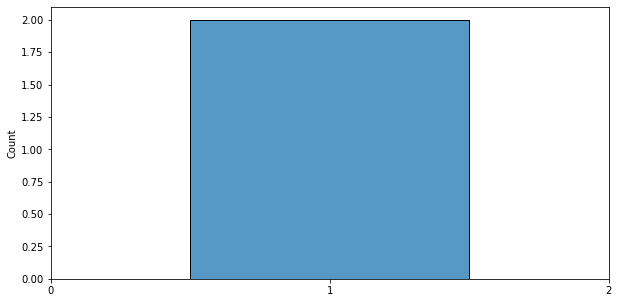

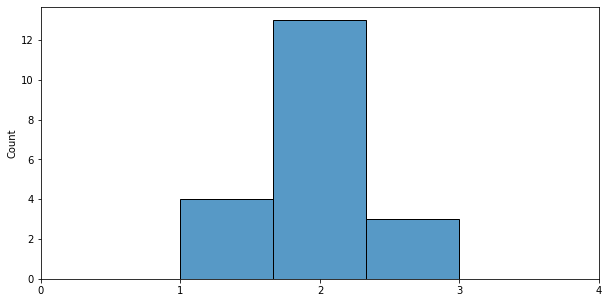

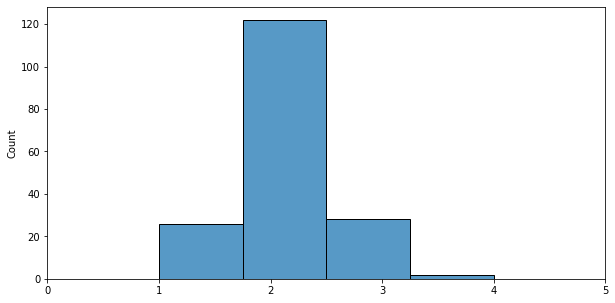

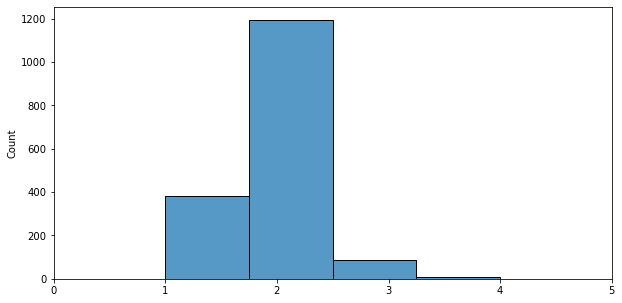

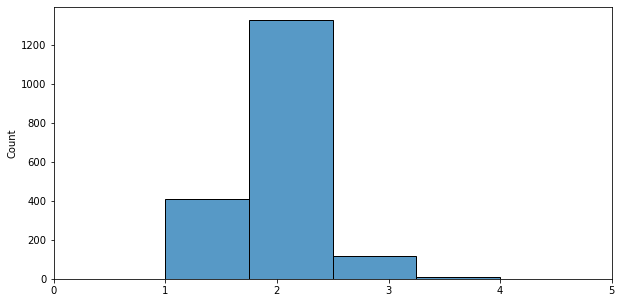

In [807]:
plot_class_ids_per_compressions(distance_all_data_dist_angle, df, 'distAngleNet/from_data')

In [808]:
for key, items in distance_all_data_dist_angle[0].items():
    if not items: continue
    i, _ = items[0]
    if df.iloc[i]['class_id'] == 0:
        print(key)
        print()

(-5141415614190870712, -4945604921626605710, -1873609022539581513, 2346163933359330056, 4396620487734455424, 8240508771209514015)

(-3876101055898742328, -1895566940966214361, -1873609022539581513, 755235464494036486, 3543492671141961816, 4396620487734455424)



### Activation compressions

In [647]:
networksDistAngle = create_networks(NetworkClass=DistAnglesNet, num_of_networks=10)
distance_all_acts_dist_angle = calculate_all_dicts_from_activations(df=df, max_distance=3, input_handling_func=calc_all_distances_angles, networks=networksDistAngle)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1068/1068 [00:06<00:00, 154.02it/s]


In [648]:
with open('data/temp/distance_all_acts_dist_angle.pkl', 'wb') as f:
    pickle.dump(distance_all_acts_dist_angle, f)

In [649]:
set_intersections_activations_dist_angle = compute_set_intersections(distance_all_acts_dist_angle)

Intersection size between sets 1 AND 2: 0
Intersection size between sets 1 AND 3: 0
Intersection size between sets 2 AND 3: 0


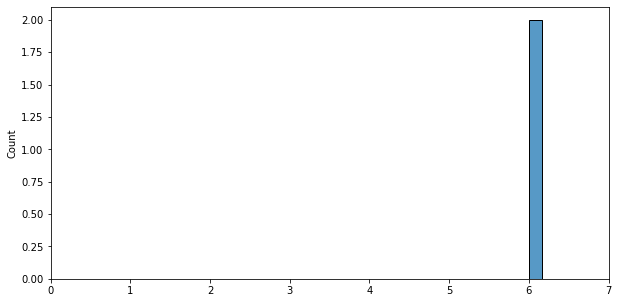

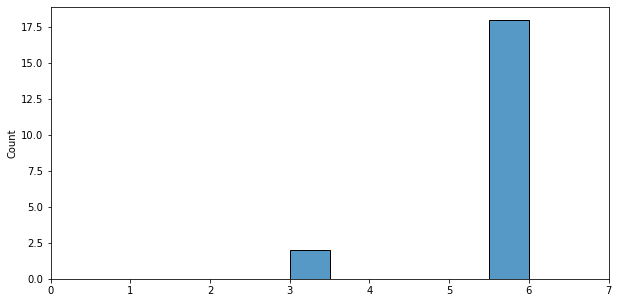

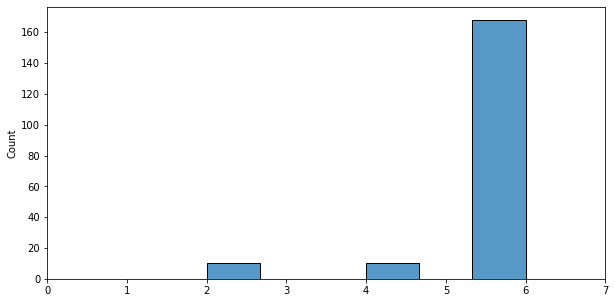

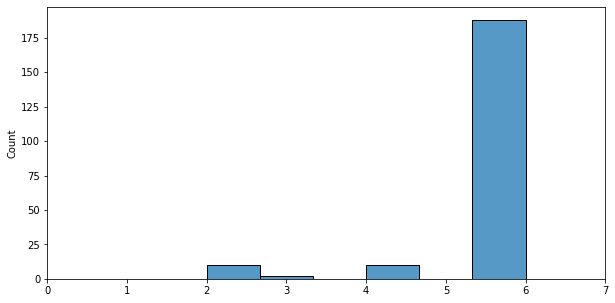

In [650]:
plot_distance_compressions(distance_all_acts_dist_angle, 'distAngleNet/from_activations')

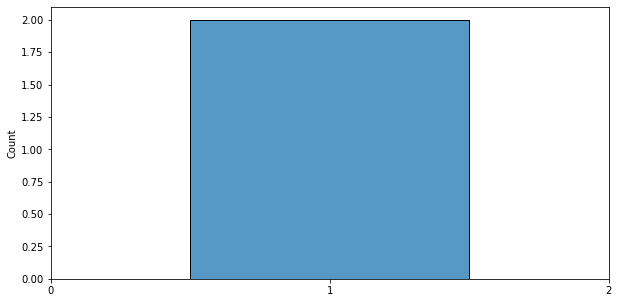

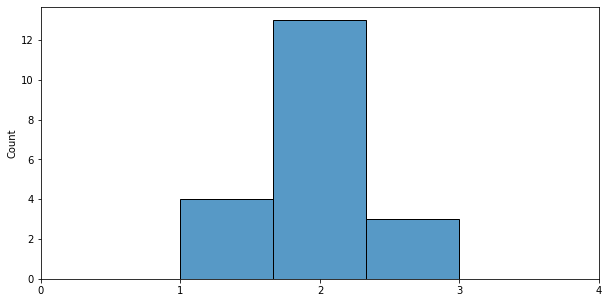

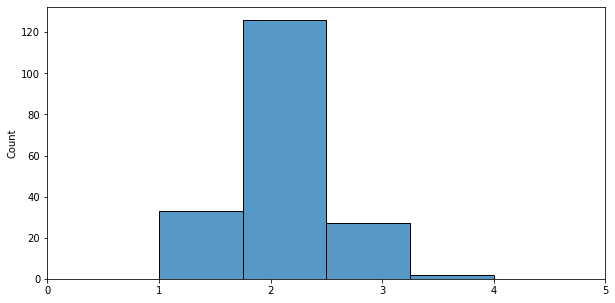

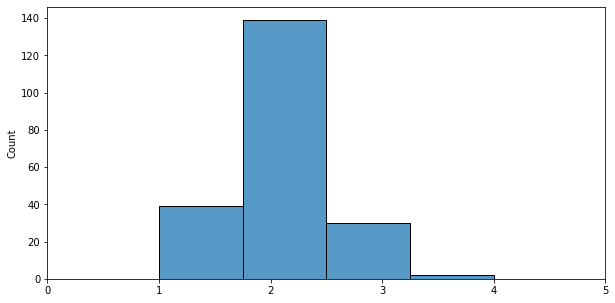

In [651]:
plot_class_ids_per_compressions(distance_all_acts_dist_angle, df, 'distAngleNet/from_activations')